<a href="https://colab.research.google.com/github/alanmejiaa/Datos-Masivos/blob/main/Practica%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 3

Tomando en cuenta las herramientas vistas en clase y los ejemplos de los cuadernos de Google colab, realizar un análisis de sentimiento de una base de datos a elección. Se revisará que utilicen al menos 3 de las herramientas mencionadas​

El conjunto de datos contiene los tweets recientes sobre la exitosa serie de Netflix "Squid Game" o "El juego del calamar", que ha batido récords.

Los datos se recopilan utilizando el paquete de Python llamado tweepy para acceder a la API de Twitter

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.dates as mdates
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura de datos
df = pd.read_csv('tweets_juego_calamar.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
3,YoMo.Mdp,Any pronouns,Where the heck is the karma\nI'm going on my s...,2021-02-14 13:21:22+00:00,3,277,1341,False,2021-10-06 12:05:04+00:00,//Blood on 1st slide\nI'm joining the squidgam...,Twitter Web App,False
4,Laura Reactions,France,I talk and I make reactions videos about shows...,2018-12-19 20:38:28+00:00,330,152,2278,False,2021-10-06 12:05:00+00:00,"The two first games, players were killed by th...",Twitter Web App,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80019 entries, 0 to 80018
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         80015 non-null  object
 1   user_location     56149 non-null  object
 2   user_description  74808 non-null  object
 3   user_created      80019 non-null  object
 4   user_followers    80019 non-null  int64 
 5   user_friends      80019 non-null  int64 
 6   user_favourites   80019 non-null  int64 
 7   user_verified     80019 non-null  bool  
 8   date              80019 non-null  object
 9   text              80019 non-null  object
 10  source            80019 non-null  object
 11  is_retweet        80019 non-null  bool  
dtypes: bool(2), int64(3), object(7)
memory usage: 6.3+ MB


In [4]:
# Se seleccionan y renombran las columnas de interés
tweets = df[['date', 'text','source']]
tweets.columns = ['fecha', 'tweet','source']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'], infer_datetime_format=True)
tweets['fecha'] = tweets['fecha'].dt.strftime('%Y-%m-%d')
tweets.head(3)

,fecha,tweet,source
0,2021-10-06,When life hits and the same time poverty strik...,Twitter for Android
1,2021-10-06,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android
2,2021-10-06,#Squidgame time,Twitter Web App


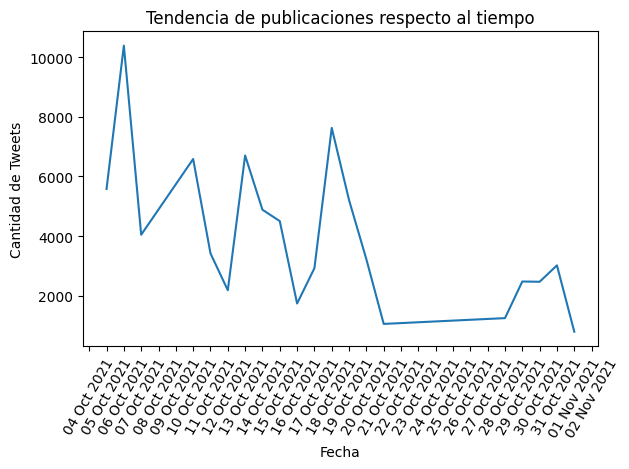

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from collections import Counter

# Distribución temporal de los tweets
conteo_tweets = Counter(tweets.fecha)

# Obtener las fechas y la cantidad de tweets
fechas_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]

# Crear el gráfico
plt.plot(fechas_unicas, cantidad_tweets)

# Configurar el formateo del eje x para mostrar por día
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # Formato "Día Mes Año"
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.title('Tendencia de publicaciones respecto al tiempo')
plt.xticks(rotation=60)  # Girar las etiquetas del eje x para mayor legibilidad
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


In [15]:
def limpiar_tokenizar(texto):
    newtex = texto.lower()
    newtex = re.sub('http\S+', ' ', newtex)
    regex = '[\!\"\#$\%\&\\*\+\,\-\.\/\:\;\<\=\>\?\@\^_\`\{\|\}\~]'
    newtex = re.sub(regex , ' ', newtex)
    newtex = re.sub("\d+", ' ', newtex)
    newtex = re.sub("\s+", ' ', newtex)
    newtex = newtex.split(sep = ' ')
    newtex = [token for token in newtex if len(token) > 1]
    return(newtex)

In [18]:
tweets['tweettoken'] = tweets['tweet'].apply(lambda x: limpiar_tokenizar(x))
tweets[['tweet', 'tweettoken']].head()

,tweet,tweettoken
0,When life hits and the same time poverty strik...,"[when, life, hits, and, the, same, time, pover..."
1,That marble episode of #SquidGame ruined me. 😭😭😭,"[that, marble, episode, of, squidgame, ruined,..."
2,#Squidgame time,"[squidgame, time]"
3,//Blood on 1st slide\nI'm joining the squidgam...,"[blood, on, st, slide, i'm, joining, the, squi..."
4,"The two first games, players were killed by th...","[the, two, first, games, players, were, killed..."


In [20]:
# Unnest de la columna tweettoken
tweets_tidy = tweets.explode(column='tweettoken') #Separa en filas las listas de tweettoken
tweets_tidy = tweets_tidy.drop(columns='tweet') #Elimina la columna de tweet original ya que tenemos el tweettoken por fila
tweets_tidy = tweets_tidy.rename(columns={'tweettoken':'token'}) #Cambiamos el nombre de tweettoken ya partido en filas
tweets_tidy = tweets_tidy.drop(columns='twtoken') #Elimina la columna de twtoken
tweets_tidy.head(3)

,fecha,source,token
0,2021-10-06,Twitter for Android,when
0,2021-10-06,Twitter for Android,life
0,2021-10-06,Twitter for Android,hits


In [21]:
temp_df = pd.DataFrame(tweets_tidy.groupby("source")["token"].count())
mean_length = temp_df["token"].mean()
std_length = temp_df["token"].std()

print("Longitud de media de los tweets:", mean_length)
print("Desviación de los tweets:", std_length)

Longitud de media de los tweets: 3973.3115384615385
Desviación de los tweets: 34267.03359189825


In [24]:
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Filtrado para excluir stopwords
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

In [26]:
# Descarga lexicon sentimientos
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [45]:
import pandas as pd

# Sentimiento promedio de cada tweet
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token",
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["fecha", "source", "sentimiento"]] \
                      .groupby(["fecha", "source"])\
                      .sum().reset_index()

tweets_sentimientos

,fecha,source,sentimiento
0,2021-10-05,Agorapulse app,4
1,2021-10-05,Blog2Social APP,-2
2,2021-10-05,Buffer,17
3,2021-10-05,Echobox,3
4,2021-10-05,Echofon,8
...,...,...,...
821,2021-11-01,Tweetbot for iΟS,-2
822,2021-11-01,Twitter Web App,155
823,2021-11-01,Twitter for Android,263
824,2021-11-01,Twitter for iPad,-2


In [47]:
import pandas as pd

# Sentimiento promedio de cada tweet
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token",
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet y se eliminan las columnas "fecha"
tweets_sentimientos = tweets_sentimientos[["source", "sentimiento"]] \
                      .groupby("source")\
                      .sum().reset_index()

# Ordenar el DataFrame por la columna "sentimiento" de mayor a menor
tweets_sentimientos = tweets_sentimientos.sort_values(by="sentimiento", ascending=False)

tweets_sentimientos

,source,sentimiento
143,Twitter for Android,23833
139,Twitter Web App,13622
146,Twitter for iPhone,8488
145,Twitter for iPad,1055
102,SocialRabbit Plugin,981
...,...,...
168,lucy's microwave,-9
3,Amplifr,-10
48,Libsyn On-Publish,-14
131,Tweetlogix,-20


Las personas que usan Twitter en su Android son las que mas contribuyen con comentarios positivos

In [48]:
print(f"Positivos: {round(100 * np.mean(tweets_sentimientos.sentimiento > 0), 2)}")
print(f"Neutros  : {round(100 * np.mean(tweets_sentimientos.sentimiento == 0), 2)}")
print(f"Negativos: {round(100 * np.mean(tweets_sentimientos.sentimiento < 0), 2)}")

Positivos: 77.17
Neutros  : 4.89
Negativos: 17.93


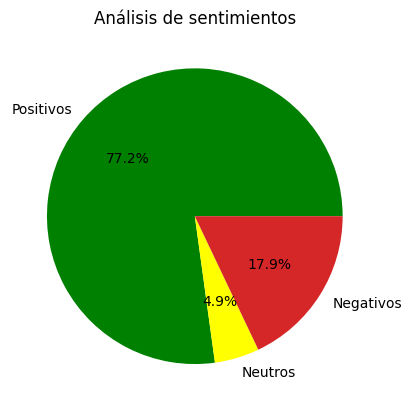

In [53]:
positivos = round(100 * np.mean(tweets_sentimientos.sentimiento > 0), 2)
neutros = round(100 * np.mean(tweets_sentimientos.sentimiento == 0), 2)
negativos = round(100 * np.mean(tweets_sentimientos.sentimiento < 0), 2)

resultados = [positivos, neutros, negativos]
etiquetas = ['Positivos', 'Neutros', 'Negativos']

# Colores personalizados
colores = ['#008000', '#FFFF00', '#d62728']

# Crear el gráfico de pastel
plt.pie(resultados, labels=etiquetas, autopct='%1.1f%%', colors=colores)
plt.title('Análisis de sentimientos')
plt.show()


El 77.2% de comentarios fueron positivos hacia la serie del juego del calamar, un 17.9% desaprobaron la serie dando comentarios negativos de ella.